# import

In [71]:
import sys
import gc
import os
import glob
import cv2
import csv
import pandas as pd
import pickle
import subprocess

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output
from IPython.display import HTML

import numpy as np
import scipy
import scipy.interpolate as interpolate
from scipy.ndimage import median_filter
from scipy.ndimage.filters import gaussian_filter1d
import scipy.optimize

In [72]:
from mycolor import set_col_extra
from util_ana import stdsig,ps_number_detect,affine_transform,ps_trj
from util_ana import label_ps,labeling,labeling_im

In [73]:
sys.path.append('./opmap/')
from opmap.videoData import VideoData
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.phaseVarianceMap import PhaseVarianceMap
from opmap.PhaseVariancePeakMap import PhaseVariancePeakMap
from opmap.util import makeMovie

# interface

In [74]:
#sys.path.append('C:/ExperimentData')
ipath = '/mnt/Jalife/ExperimentData/'
opath = "/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/"
out_date = "20190717"
extra_dir = "/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/ExTRa_result/"

In [81]:
f_start = 0
f_end = 2000
mrate_optical = 80
mrate_extra = 20
mask_alpha = 0.7

## functions

In [76]:
def saveMovie(mov_type, dir_path):
    if mov_type == 'optical': m_rate = mrate_optical
    if mov_type == 'extra': m_rate = mrate_extra
    cmd = 'ffmpeg -r {0} -y -i "{1}/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}.mp4"'.format(m_rate, dir_path.rstrip('/'))
    os.system(cmd)

In [101]:
def applyMask(target_path, mask_path):
    #weight_mask = mask_params["Propotion"]

    files = sorted(glob.glob(os.path.join(target_path,"*.png")))
    img_mask = cv2.imread(msk_path)
    
    for i,fi in enumerate(files):
        
        img = cv2.imread(fi)
        img_q = cv2.imread(fi)
        img_q[(mask_vroi == mask_vroi)] = img_mask[(mask_vroi == mask_vroi)]
        img_masked = cv2.addWeighted(img_q, mask_alpha, img, 1-mask_alpha, 0)
        
        save_path = target_path.rstrip('/')+'_mask'
        if not os.path.exists(save_path): os.makedirs(save_path)
        cv2.imwrite(os.path.join(save_path,"{0:0>6}.png".format(i)),img_masked)
        
    return save_path

# ExTRa設定ファイルの読み込み

### 電極位置情報

In [78]:
pos_unip = np.load("/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/util/extra_unip.npy")       # ExTRa座標上のUnipolar電極位置
pos_bip = np.load("/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/util/extra_bip.npy")         # ExTRa座標上のBipolar電極位置
pos_bip41 = np.load("/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/util/extra_bip41.npy")     # ExTRa座標上のBipolar電極位置(仮想含む)
extra_bip41 = np.load("/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/util/extra_bip_map.npy") # ExTRa表示座標上のBipolar電極位置(仮想含む)

(0, 95)

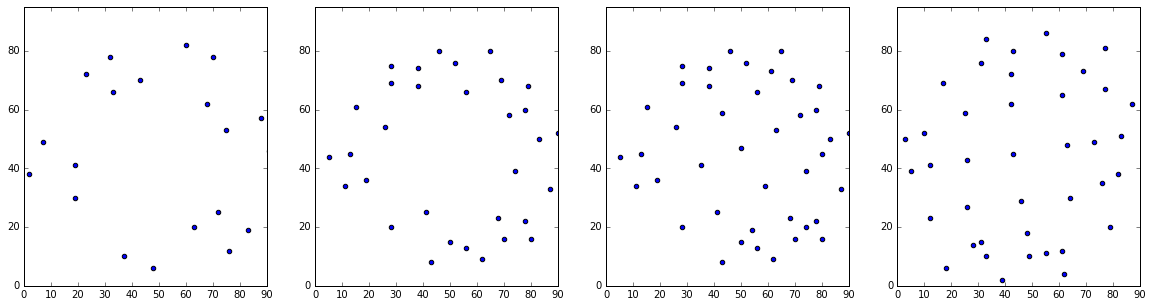

In [40]:
fig=plt.figure(figsize=(20,5))
plt.axis('equal')
ax = plt.subplot(141)
x, y, _ = np.transpose(pos_unip)
ax.scatter(x, y)
ax.set_xlim(0,90)
ax.set_ylim(0,95)
ax = plt.subplot(142)
x, y, _ = np.transpose(pos_bip)
ax.scatter(x, y)
ax.set_xlim(0,90)
ax.set_ylim(0,95)
ax = plt.subplot(143)
x, y, _ = np.transpose(pos_bip41)
ax.scatter(x, y)
ax.set_xlim(0,90)
ax.set_ylim(0,95)
ax = plt.subplot(144)
x, y, _ = np.transpose(extra_bip41)
ax.scatter(x, y)
ax.set_xlim(0,90)
ax.set_ylim(0,95)

### ROI

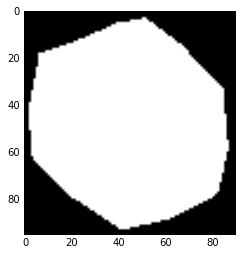

In [79]:
extra_roi = np.load("/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/util/ExTRa_roi.npy")
plt.imshow(extra_roi, cmap='gray')

### カラーマップ

In [44]:
cmap_extra = set_col_extra()
cmap_extra

# Optical設定ファイルの読み込み

### 電極配置情報（ｘ配置番号）

In [80]:
elec_list = np.load(os.path.join(opath,"util/elec_list.npy"))
elec_list.shape

(45, 20, 3)

# main loop

In [84]:
#解析パラメータ
ana_params = {
    "optical":{
        "cam":{
            "Type":"sa4",
        },#Analysis = [OFF,ON,Image,Movie]
        "vmem":{
            "Diff_min":40,
            "Diff_max":100,
            "Closing":5,
            "Erosion":5,
            "Smooth":15,
            "Rect":{
                "Top":0,
                "Left":0,
                "Bottom":0,
                "Right":0
            }
        },#[ON] 
        "pmap":{
            "Smooth":0,
            "Shrink":2,
            "Sigma_xy":4,
        },#ExTra_color=[OFF,ON,ADD]
        "pvmap":{
            "Size":5,
            "Threshold":0.65
        },
    },"extra":{
       "extra_pmap":{
        },
        "extra_pvmap":{
            "Size":5,
            "Threshold":0.65
        },
    }
}
cam_params = ana_params["optical"]["cam"]
vmem_params = ana_params["optical"]["vmem"]
pmap_params = ana_params["optical"]["pmap"]
pvmap_params = ana_params["optical"]["pvmap"]
epmap_params = ana_params["extra"]["extra_pmap"]
epvmap_params = ana_params["extra"]["extra_pvmap"]

# リストimport

In [95]:
ana_list_all = pd.read_csv("./session_sw_all.csv")
ana_list_all

,sample,session,elec_pattern,extra_path
0,20180425-1,5,0,20180425_rabbit3/ExTRa/e002_1532VT
1,20180425-1,9,0,20180425_rabbit3/ExTRa/e006_1612VT
2,20180425-1,12,0,20180425_rabbit3/ExTRa/e009_1630VT
3,20180426-1,6,1,20180426_rabbit4/ExTRa/e001_1048VT
4,20180426-1,10,3,20190628/e004_1058VT
5,20180426-1,13,4,20180426_rabbit4/ExTRa/e007_1105VT
6,20180426-1,19,5,20180426_rabbit4/ExTRa/e011_1122VT
7,20180426-1,21,5,20180426_rabbit4/ExTRa/e013_1139VT
8,20180612-1,6,6,20180612_rabbit5/ExTRa/
9,20180612-1,8,7,20180612_rabbit5/ExTRa/e003_1541VT


In [97]:
ana_list_rep = pd.read_csv("./session_sw_representative.csv")
ana_list_rep

,﻿id,sample,session,elec_pattern,extra_path,delay
0,25,20180426-1,10,3,20190628/e004_1058VT,136
1,68,20180614-1,9,10,20180614_rabbit6/ExTRa/e005_1455VT,0
2,88,20180731-1,13,15,20180731/ExTRa/e010_1237VT,0
3,95,20180731-1,20,20,20190628/e017_1314VT,136
4,105,20180731-1,30,22,20190628/e027_1332VT,136
5,148,20181122-1,20,35,20190628/e018_11221237,136
6,160,20190123-1,4,39,20190320/e004_01231521,136
7,168,20190123-1,12,41,20190320/,136
8,178,20190123-1,22,44,20190320/,136


## Optical

In [ ]:
for i, ana_data in (ana_list_rep.iterrows()):
    
    session = "{0}/C001H001S{1:0>4}".format(ana_data["sample"],ana_data["session"])
    src_path = os.path.join(ipath, session)
    
    save_path = os.path.join(os.path.join(opath,out_date), session)
    if not os.path.exists(save_path): os.makedirs(save_path)
        
    print(src_path,save_path)
       
    # Image size check
    fsrc_path = os.path.join(src_path,"C001H001S{0:0>4}".format(ana_data["session"])+"000001.raww")
    if(os.path.getsize(fsrc_path) < 150000):
        img_size = 256
    elif(os.path.getsize(fsrc_path) > 600000):
        img_size = 1024
    else:
        img_size = 512
        
    # Calculate affine transformed mask
    shrink = pmap_params["Shrink"]
    pos_fig = elec_list[ana_data["elec_pattern"],:,:] # 20 x 3
    [pos_af_unip_vmem,pos_af_bip41_vmem,affine_t_vmem] = affine_transform(p_fig=pos_fig,p_ref=pos_unip,p_bip=pos_bip41)
    [pos_af_unip     ,pos_af_bip41     ,affine_t]      = affine_transform(p_fig=pos_fig//shrink,p_ref=pos_unip,p_bip=pos_bip41)
    roi_extra_on_optical_v = cv2.warpAffine(extra_roi[:,::-1],affine_t_vmem[:2], (img_size, img_size),flags = cv2.INTER_NEAREST)
    roi_extra_on_optical_p = cv2.warpAffine(extra_roi[:,::-1], affine_t[:2], (img_size//shrink, img_size//shrink),flags = cv2.INTER_NEAREST)
    
    mask_vroi = np.copy(roi_extra_on_optical_v)       #vmem size のExTRaのROI
    mask_proi = np.copy(roi_extra_on_optical_p)#pmap size のExTRaのROI
    mask_vroi[(mask_vroi == 1)] = np.nan # transparent
    mask_proi[(mask_proi == 1)] = np.nan # transparent
    
    path_mask_vroi = os.path.join(save_path,"mask_vroi.png")
    path_mask_proi = os.path.join(save_path,"mask_proi.png")
    plt.imsave(path_mask_vroi, mask_vroi, cmap = "gray", vmax= 1,vmin=0)
    plt.imsave(path_mask_proi, mask_proi, cmap = "gray", vmax= 1,vmin=0)
    
    # RawCam
    cam = RawCam(
        src_path,
        cam_type=cam_params["Type"],
        image_height=img_size, image_width=img_size,
        frame_start=f_start,
        frame_end=f_end)    

    save_dir = os.path.join(save_path, "cam")
    if not os.path.exists: os.makedirs(save_dir)
    plt.imsave( os.path.join(save_dir, 'cam.png'),  cam.data[0,:,:])
    
    # vmem
    vmem = VmemMap(cam)
    vmem.setDiffRange(diff_min = vmem_params["Diff_min"],diff_max = vmem_params["Diff_max"])
    vmem.morphROI(closing = vmem_params["Closing"])
    vmem.morphROI(erosion = vmem_params["Erosion"])
    vmem.smooth(vmem_params["Smooth"])
    vmem.data *= vmem.roi
    
    save_dir = os.path.join(save_path,"vmem")
    vmem.saveImage( save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(os.path.join(save_path,"vmem"), path_mask_vroi)
    saveMovie('optical', save_dir)

    # pmap
    pmap = PhaseMapHilbert(vmem, width = img_size//pmap_params["Shrink"], sigma_xy = pmap_params["Sigma_xy"])
    pmap.data += pmap_params["Offset"]
    pmap.data[(pmap.data> np.pi)] -= 2*np.pi
    pmap.data[(pmap.data<-np.pi)] += 2*np.pi
    pmap.data *= pmap.roi
    pmap.data *= -1 # extraの位相変化の方向と合わせる
    pmap.smooth(pmap_params["Smooth"])
    
    save_dir = os.path.join(save_path,"pmap")
    pmap.cmap = cmap_extra
    pmap.saveImage(save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(save_dir, path_mask_proi)
    saveMovie('optical', save_dir)

    # pvmap
    pvmap = PhaseVarianceMap(pmap,size = pvmap_params["Size"])

    save_dir = os.path.join(save_path,"pvmap")
    pvmap.saveImage(save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(save_dir, path_mask_proi)
    saveMovie('optical', save_dir)
    
    # psmap
    psmap = PhaseVariancePeakMap(pvmap)
    
    save_dir = os.path.join(save_path,"psmap")
    psmap.saveImage(save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(save_dir, path_mask_proi)
    saveMovie('optical', save_dir)
    
  

/mnt/Jalife/ExperimentData/20180426-1/C001H001S0010 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190717/20180426-1/C001H001S0010


## Extra

In [99]:
for i, ana_data in (ana_list_rep.iterrows()):

    src_path = os.path.join(extra_dir, ana_data["extra_path"])
    
    session = "{0}/C001H001S{1:0>4}".format(ana_data["sample"],ana_data["session"])
    save_path = os.path.join(os.path.join(opath, out_date), session)
    if not os.path.exists(save_path): os.makedirs(save_path)
    
    print(src_path,save_path)

    #pmap
    pmap = VideoData(
        length = len(np.arange(f_start, f_end)),
        width = 96, height = 96
    )
    pmap.data[:,95:,:] = np.nan
    pmap.data[:,:,90:] = np.nan
    pmap.cmap = cmap_extra
    
    file_delay = int(ana_data["delay"])//4
    phase_files = sorted(glob.glob(os.path.join(src_path, "phase/*.csv")))
    for m, fi in enumerate(phase_files):
        if m < file_delay: continue
        pmap_extra = np.genfromtxt(fi, delimiter=',')[:,::1].astype(np.float64)
        pmap.data[m-file_delay,:pmap_extra.shape[0],:pmap_extra.shape[1]] = np.deg2rad(pmap_extra)

    save_dir = os.path.join(save_path,"pmap_ex")
    pmap.cmap = cmap_extra
    pmap.saveImage(save_dir)
    saveMovie('extra', save_dir)

    # pvmap
    pvmap = PhaseVarianceMap(pmap,size = pvmap_params["Size"])

    save_dir = os.path.join(save_path,"pvmap_ex")
    pvmap.saveImage(save_dir)
    saveMovie('extra', save_dir)
    
    # psmap
    psmap = PhaseVariancePeakMap(pvmap)
    
    save_dir = os.path.join(save_path,"psmap_ex")
    psmap.saveImage(save_dir)
    saveMovie('extra', save_dir)


/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/ExTRa_result/20190628/e004_1058VT /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190717/20180426-1/C001H001S0010
/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/ExTRa_result/20180614_rabbit6/ExTRa/e005_1455VT /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190717/20180614-1/C001H001S0009


KeyboardInterrupt: 